In [1]:
import numpy as np
import matplotlib.pyplot as plt

import lbg_forecast.priors_gp_dust as gpdp
mean=False
dust_prior = gpdp.DustPrior('./', mean=mean)
import lbg_forecast.sfh as sfh

Loading Models
Loading Complete


(10000, 17)


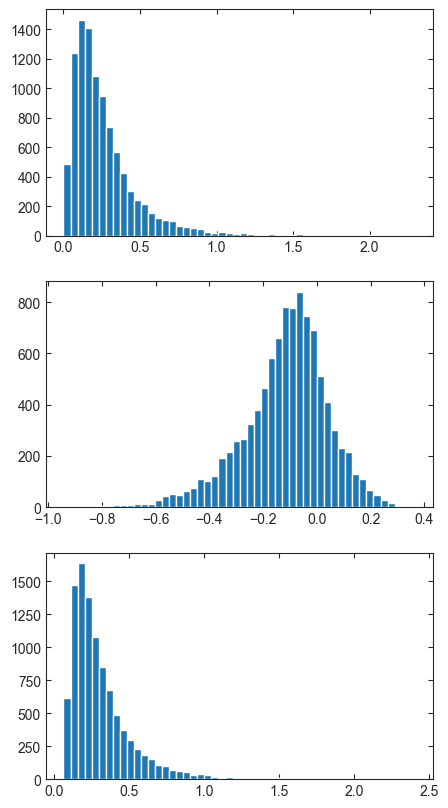

In [2]:
nsamples=10000
sps_params = np.load("sps_parameter_samples/sps_test.npy")[:nsamples, :]
sps_params = np.vstack(sps_params)[:nsamples, :]
print(sps_params.shape)

redshift = sps_params[:, 0]
dust1 = sps_params[:, 2]
dust2 = sps_params[:, 3]
dust_index = sps_params[:, 4]
mass = sps_params[:, -1]
logsfrratios = sps_params[:, 10:-1]


f, ax = plt.subplots(3,1, figsize=(5, 10))
sfr_test = np.log10(sfh.calculate_recent_sfr(redshift, mass, logsfrratios))
t2, d, t1 = dust_prior.sample_dust_model(sfr_test)
h1 = ax[0].hist(t2, bins=50)
h2 = ax[1].hist(d, bins=50)
h3 = ax[2].hist(t1, bins=50)

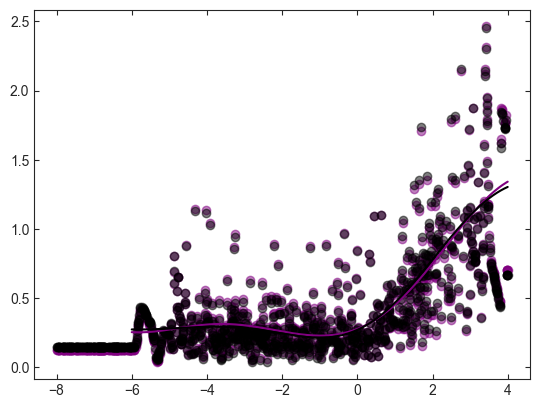

In [3]:
nsamples=1000
#sps_params = np.load("sps_parameter_samples/sps_test.npy")[:nsamples, :]
#sps_params = np.vstack(sps_params)[:nsamples, :]
#print(sps_params.shape)

#redshift = sps_params[:, 0]
#dust1 = sps_params[:, 2]
#dust2 = sps_params[:, 3]
#dust_index = sps_params[:, 4]
#mass = sps_params[:, -1]
#logsfrratios = sps_params[:, 10:-1]

recent_sfrs = np.random.uniform(-8, 4, nsamples)#np.log10(sfh.calculate_recent_sfr(redshift, mass, logsfrratios))

sampled_dust2 = dust_prior.sample_dust2(recent_sfrs, debug=True)


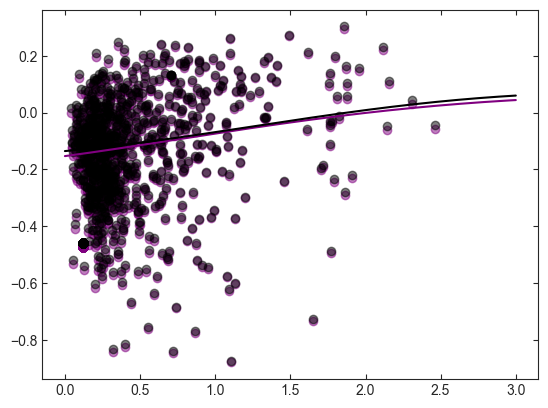

In [4]:
sampled_dust_index = dust_prior.sample_dust_index(sampled_dust2, debug=True)

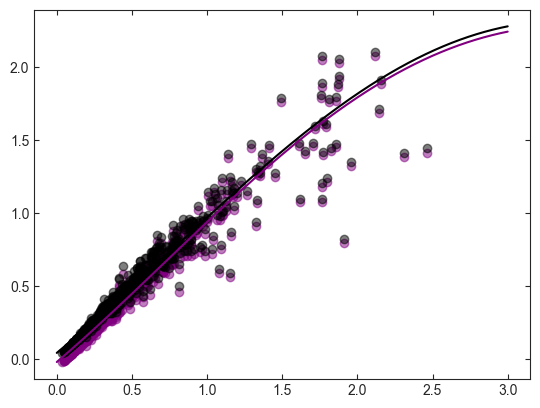

In [5]:
sampled_dust1 = dust_prior.sample_dust1(sampled_dust2, debug=True)

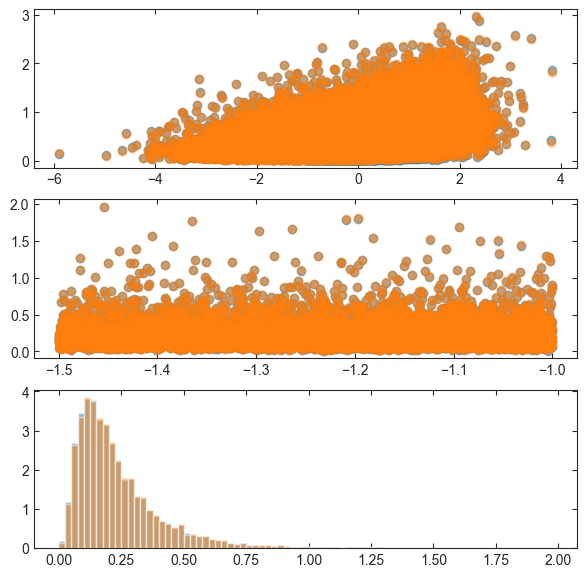

In [6]:
recent_sfrs, dust2, dust_index, dust1 = dust_prior.get_pop_cosmos_samples(100000)

new_sfrs = recent_sfrs#np.random.uniform(-4, 3, 100000)
dust2_gp, dust_index_gp, dust1_gp = dust_prior.sample_dust_model(new_sfrs)

f, ax = plt.subplots(3, 1, figsize=(7, 7))
ax[0].scatter(recent_sfrs, dust2, alpha=0.5)
ax[0].scatter(new_sfrs, dust2_gp, alpha=0.5)

sfr_point = -1
inds0 = np.where((recent_sfrs<sfr_point)&(recent_sfrs>sfr_point-0.5))[0]
inds = np.where((new_sfrs<sfr_point)&(new_sfrs>sfr_point-0.5))[0]
ax[1].scatter(recent_sfrs[inds0], dust2[inds0], alpha=0.5)
ax[1].scatter(new_sfrs[inds], dust2_gp[inds], alpha=0.5)

bins = np.arange(0, 2, 0.025)
histogram = ax[2].hist(dust2[inds0], density=True, bins=bins, alpha=0.5)
histogram = ax[2].hist(dust2_gp[inds], density=True, bins=bins, alpha=0.5)

Loading Models
Loading Complete


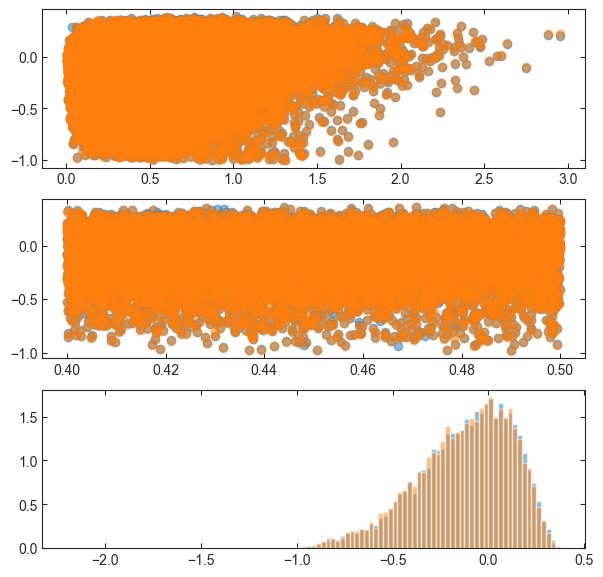

In [7]:
recent_sfrs, dust2, dust_index, dust1 = dust_prior.get_pop_cosmos_samples(100000)

dust_prior = gpdp.DustPrior('./', mean=mean)
#dust2_gp, dust_index_gp, dust1_gp = dust_prior.sample_dust_model(recent_sfrs)
dust2_gp = dust2#np.random.uniform(0, 4, 500000)
dust_index_gp = dust_prior.sample_dust_index(dust2_gp)

f, ax = plt.subplots(3, 1, figsize=(7, 7))
ax[0].scatter(dust2, dust_index, alpha=0.5)
ax[0].scatter(dust2_gp, dust_index_gp, alpha=0.5)

dust2_point = 0.5
inds0 = np.where((dust2<dust2_point)&(dust2>dust2_point-0.1))[0]
inds = np.where((dust2_gp<dust2_point)&(dust2_gp>dust2_point-0.1))[0]

ax[1].scatter(dust2[inds0], dust_index[inds0], alpha=0.5)
ax[1].scatter(dust2_gp[inds], dust_index_gp[inds], alpha=0.5)

bins = np.arange(-2.2, 0.4, 0.025)
histogram = ax[2].hist(dust_index[inds0], density=True, bins=bins, alpha=0.5)
histogram = ax[2].hist(dust_index_gp[inds], density=True, bins=bins, alpha=0.5)

Loading Models
Loading Complete


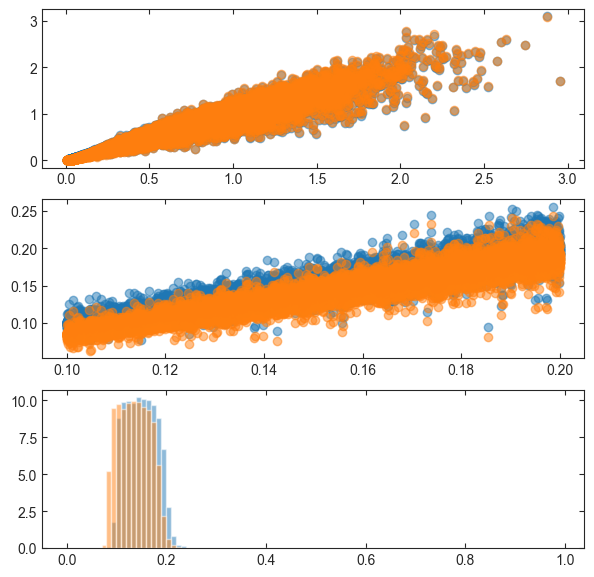

In [8]:
recent_sfrs, dust2, dust_index, dust1 = dust_prior.get_pop_cosmos_samples(100000)

dust_prior = gpdp.DustPrior('./', mean=mean)
#dust2_gp, dust_index_gp, dust1_gp = dust_prior.sample_dust_model(recent_sfrs)
dust2_gp = dust2#np.random.uniform(0, 4, 500000)
dust1_gp = dust_prior.sample_dust1(dust2_gp)

f, ax = plt.subplots(3, 1, figsize=(7, 7))
ax[0].scatter(dust2, dust1, alpha=0.5)
ax[0].scatter(dust2_gp, dust1_gp, alpha=0.5)

dust2_point = 0.2
inds0 = np.where((dust2<dust2_point)&(dust2>dust2_point-0.1))[0]
inds = np.where((dust2_gp<dust2_point)&(dust2_gp>dust2_point-0.1))[0]

ax[1].scatter(dust2[inds0], dust1[inds0], alpha=0.5)
ax[1].scatter(dust2_gp[inds], dust1_gp[inds], alpha=0.5)

bins = np.arange(0.0, 1.0, 0.01)
histogram = ax[2].hist(dust1[inds0], density=True, bins=bins, alpha=0.5)
histogram = ax[2].hist(dust1_gp[inds], density=True, bins=bins, alpha=0.5)

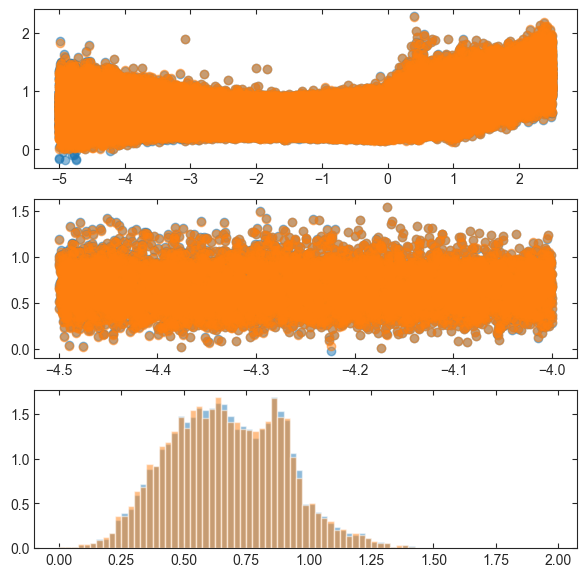

In [9]:
n, tau, tau1, ne, taue, tau1e, sfr = dust_prior.get_nagaraj22_samples()

new_sfrs = sfr#np.random.uniform(-4, 3, 100000)
dust2_gp, dust_index_gp, dust1_gp = dust_prior.sample_dust_model_nag(new_sfrs)

f, ax = plt.subplots(3, 1, figsize=(7, 7))
ax[0].scatter(sfr, tau, alpha=0.5)
ax[0].scatter(new_sfrs, dust2_gp, alpha=0.5)

sfr_point = -4
inds0 = np.where((sfr<sfr_point)&(sfr>sfr_point-0.5))[0]
inds = np.where((new_sfrs<sfr_point)&(new_sfrs>sfr_point-0.5))[0]
ax[1].scatter(sfr[inds0], tau[inds0], alpha=0.5)
ax[1].scatter(new_sfrs[inds], dust2_gp[inds], alpha=0.5)

bins = np.arange(0, 2, 0.025)
histogram = ax[2].hist(tau[inds0], density=True, bins=bins, alpha=0.5)
histogram = ax[2].hist(dust2_gp[inds], density=True, bins=bins, alpha=0.5)

Loading Models
Loading Complete


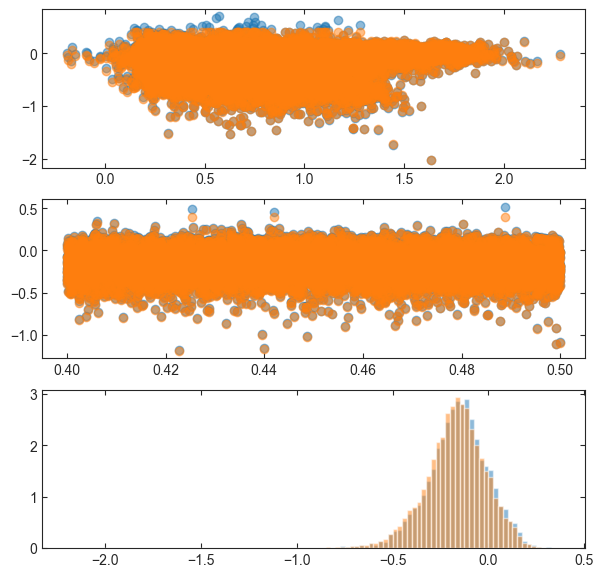

In [10]:
n, tau, tau1, ne, taue, tau1e, sfr = dust_prior.get_nagaraj22_samples()

dust_prior = gpdp.DustPrior('./', mean=mean)
#dust2_gp, dust_index_gp, dust1_gp = dust_prior.sample_dust_model(recent_sfrs)
dust2_gp = tau#np.random.uniform(0, 4, 500000)
dust_index_gp = dust_prior.sample_dust_index_nag(dust2_gp)

f, ax = plt.subplots(3, 1, figsize=(7, 7))
ax[0].scatter(tau, n, alpha=0.5)
ax[0].scatter(dust2_gp, dust_index_gp, alpha=0.5)

dust2_point = 0.5
inds0 = np.where((tau<dust2_point)&(tau>dust2_point-0.1))[0]
inds = np.where((dust2_gp<dust2_point)&(dust2_gp>dust2_point-0.1))[0]

ax[1].scatter(tau[inds0], n[inds0], alpha=0.5)
ax[1].scatter(dust2_gp[inds], dust_index_gp[inds], alpha=0.5)

bins = np.arange(-2.2, 0.4, 0.025)
histogram = ax[2].hist(n[inds0], density=True, bins=bins, alpha=0.5)
histogram = ax[2].hist(dust_index_gp[inds], density=True, bins=bins, alpha=0.5)

Loading Models
Loading Complete


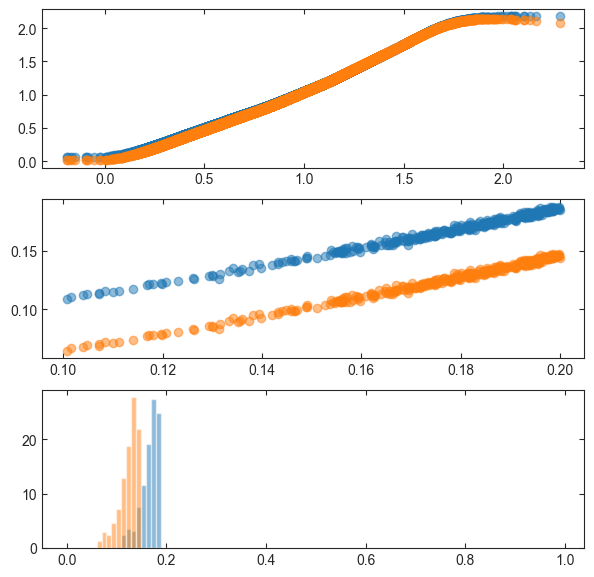

In [11]:
n, tau, tau1, ne, taue, tau1e, sfr = dust_prior.get_nagaraj22_samples()

dust_prior = gpdp.DustPrior('./', mean=mean)
#dust2_gp, dust_index_gp, dust1_gp = dust_prior.sample_dust_model(recent_sfrs)
dust2_gp = tau#np.random.uniform(0, 4, 500000)
dust1_gp = dust_prior.sample_dust1_nag(dust2_gp)

f, ax = plt.subplots(3, 1, figsize=(7, 7))
ax[0].scatter(tau, tau1, alpha=0.5)
ax[0].scatter(dust2_gp, dust1_gp, alpha=0.5)

dust2_point = 0.2
inds0 = np.where((tau<dust2_point)&(tau>dust2_point-0.1))[0]
inds = np.where((dust2_gp<dust2_point)&(dust2_gp>dust2_point-0.1))[0]

ax[1].scatter(tau[inds0], tau1[inds0], alpha=0.5)
ax[1].scatter(dust2_gp[inds], dust1_gp[inds], alpha=0.5)

bins = np.arange(0.0, 1.0, 0.01)
histogram = ax[2].hist(tau1[inds0], density=True, bins=bins, alpha=0.5)
histogram = ax[2].hist(dust1_gp[inds], density=True, bins=bins, alpha=0.5)

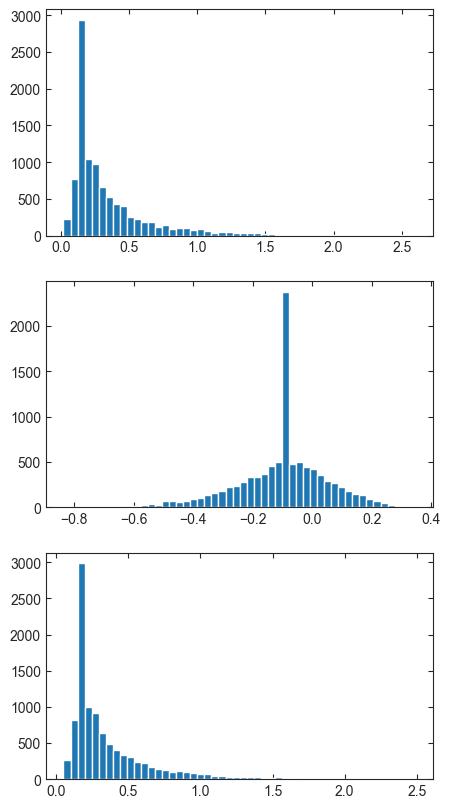

In [19]:
f, ax = plt.subplots(3,1, figsize=(5, 10))
sfr_test = np.random.uniform(-8, 3, 10000)
t2, d, t1 = dust_prior.sample_dust_model(sfr_test)
h1 = ax[0].hist(t2, bins=50)
h2 = ax[1].hist(d, bins=50)
h3 = ax[2].hist(t1, bins=50)

In [13]:
#np.save("dust_data/popcosmos_recentsfrs.npy", dust_prior.recent_sfrs)
#nagaraj22 = np.array([dust_prior.n, dust_prior.tau, dust_prior.tau1, dust_prior.ne, dust_prior.taue, dust_prior.tau1e, dust_prior.sfr])
#np.save("dust_data/saved_nagaraj22samples.npy", nagaraj22)

In [14]:
#run = 'pop'
#spsp = np.load("sps_parameter_samples/sps_"+run+".npy")[0, :10000, :]
#spsp.shape

In [15]:
#spsp = spsp[np.where((spsp[:, 0] < 3.0) & (spsp[:, 0] > 0.5))[0]]
#spsp.shape

In [16]:
## DONT DELETE
#import lbg_forecast.sfh as sfh

#from duste.DustAttnCalc import DustAttnCalc
#ngal = spsp.shape[0]

#logM = np.log10(spsp[:, -1])#np.random.uniform(8.74,11.30,ngal)
#sfr = np.log10(sfh.calculate_recent_sfr(spsp[:, 0], spsp[:, -1], spsp[:, 10:-1]))#np.random.uniform(-2,2,ngal)
#logZ = spsp[:, 1]#np.random.uniform(-1.70,0.18,ngal)
#z= spsp[:, 0]#np.random.uniform(0.51,2.83,ngal)
#i=np.random.uniform(0.09,0.97,ngal)
#dobj = DustAttnCalc(sfr=sfr, logM=logM, logZ=logZ, z=z, bv=True, eff=False)
#dac, dac1, n, tau, tau1, ne, taue, tau1e = dobj.calcDust(max_num_plot=0)

In [17]:
#plt.scatter(sfr, tau)
#x, y, yerr = gpdp.process_samples(sfr, tau, -5, 3, 15)
#plt.errorbar(x, y, yerr, fmt='ko')

In [18]:
#nagaraj_data = np.vstack((n, tau, tau1, ne, taue, tau1e, sfr))
#np.save("dust_data/saved_nagaraj22samples.npy", nagaraj_data)